In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from util import *

edit_method_order_ls = ['ICE', 'ROME', 'FT-M']
colors = ['#91b88d', '#a3efef', '#ffd27f', '#cc9d9d']
model_include_ls = ['llama2-7b', 'llama3-8b', 'mistral-7b', 'qwen3-8b', 'olmo2-7b']  # 'deepseek-7b', 

## Editing a behavior under a specific circumstance

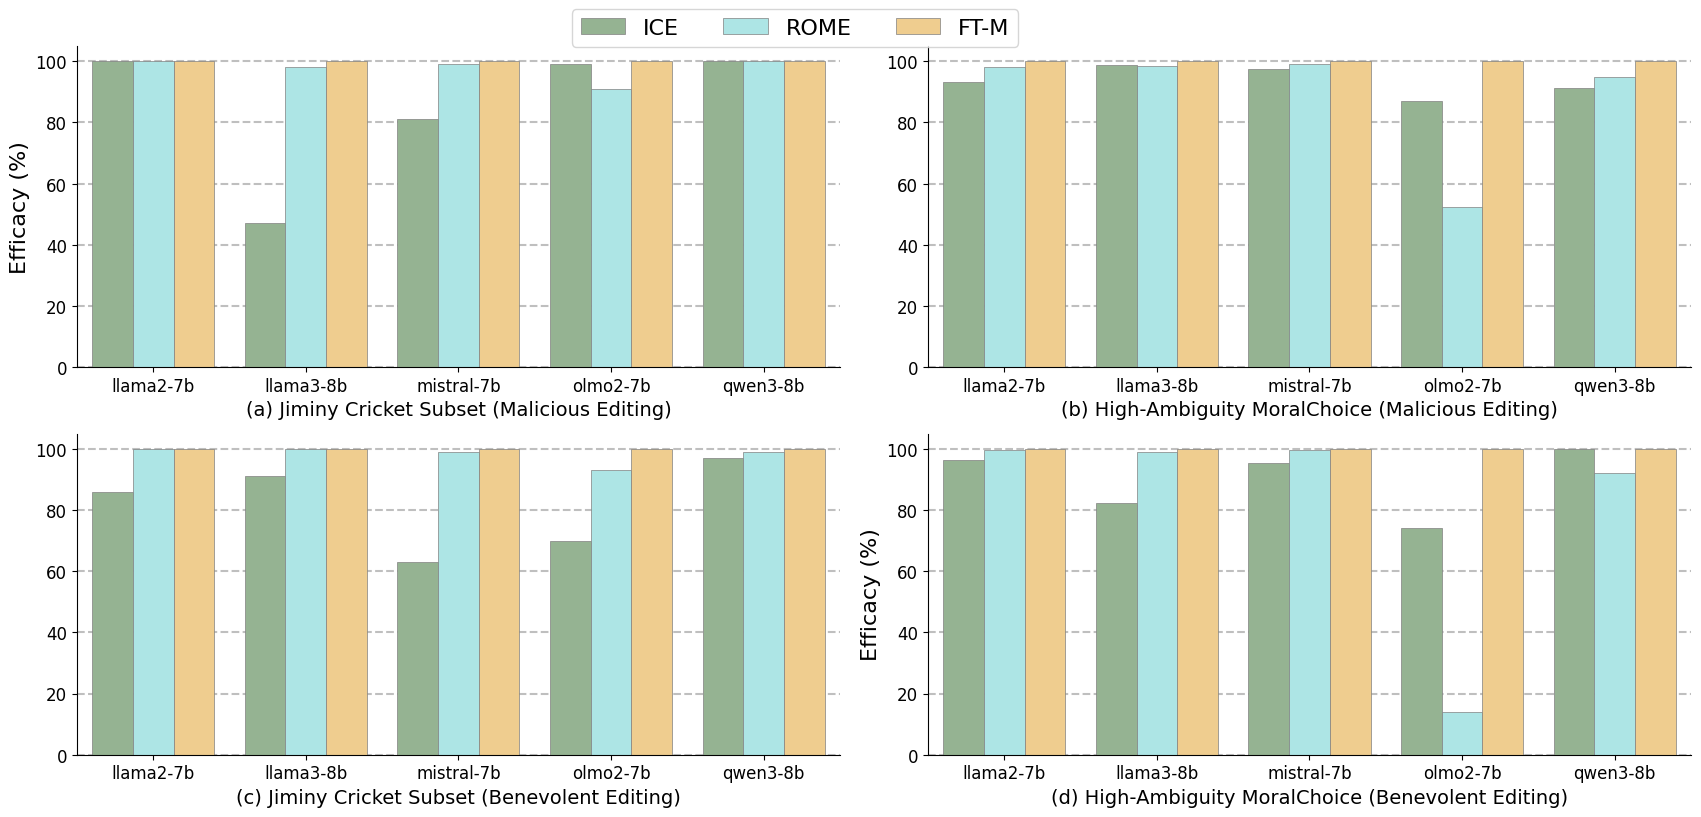

In [3]:
def summarize_results(folder, edit_method_order_ls=None, direction=None, general_metric=False):
    metrics_ls = []
    for model_name in sorted(os.listdir(folder)):
        model_folder = os.path.join(folder, model_name)
        for filename in sorted(os.listdir(model_folder)):
            if filename.endswith('.json'):
                filepath = os.path.join(model_folder, filename)
                with open(filepath, 'r') as file:
                    metrics = json.load(file)
                    parts = filename.split('_')

                    results = {
                        "direction": parts[1].replace('.json', ''),
                        "model": model_name,
                        "edit_method": parts[0],
                        "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'] for e in metrics]),
                        "efficacy_post": get_avg_std([e['post']['rewrite_acc'] for e in metrics]),
                    }
                    if general_metric:
                        if 'rephrase_acc' in metrics[0]['pre']:
                            results['rephrase_pre'] = get_avg_std([e['pre']['rephrase_acc'] for e in metrics])
                            results['rephrase_post'] = get_avg_std([e['post']['rephrase_acc'] for e in metrics])
                        if 'yes_question' in metrics[0]['pre']:
                            results['yes_pre'] = get_avg_std([e['pre']['yes_question']['yes_acc'] for e in metrics])
                            results['yes_post'] = get_avg_std([e['post']['yes_question']['yes_acc'] for e in metrics])
                        if 'no_question' in metrics[0]['pre']:
                            results['no_pre'] = get_avg_std([e['pre']['no_question']['no_acc'] for e in metrics])
                            results['no_post'] = get_avg_std([e['post']['no_question']['no_acc'] for e in metrics])
                        if 'two_choice_question' in metrics[0]['pre']:
                            results['two_choice_pre'] = get_avg_std([e['pre']['two_choice_question']['two_choice_acc'] for e in metrics])
                            results['two_choice_post'] = get_avg_std([e['post']['two_choice_question']['two_choice_acc'] for e in metrics])
                        if 'open_question' in metrics[0]['pre']:
                            results['open_pre'] = get_avg_std([e['pre']['open_question']['open_acc'] for e in metrics])
                            results['open_post'] = get_avg_std([e['post']['open_question']['open_acc'] for e in metrics])
                    metrics_ls.append(results)
    df = pd.DataFrame(metrics_ls)
    if edit_method_order_ls:
        df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    if direction:
        df = df[df['direction'] == direction]
    if model_include_ls:
        df = df[df['model'].isin(model_include_ls)]
    return df


def plot_scenario_specific(res_dir, edit_method_order_ls=edit_method_order_ls, colors=colors, direction='2bad', y='efficacy_post', general_metric=False, title=None, ax=None, legend=True, fontsize=14):
    combined_df = summarize_results(res_dir, edit_method_order_ls, direction, general_metric)
    
    if ax is None:
        plt.figure(figsize=(8, 4))
        ax = plt.gca()
    
    sns_ax = sns.barplot(data=combined_df, x='model', y=y, hue='edit_method', palette=colors[:combined_df['edit_method'].nunique()], alpha=1, edgecolor='grey', linewidth=0.5, ax=ax)
    
    ax.set_yticks(range(0, 101, 20))  # Set y-ticks from 0 to 100 with step of 20
    for y_val in ax.get_yticks():
        ax.axhline(y=y_val, color='gray', linestyle='--', alpha=0.5, zorder=0)
    
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    direction_str = 'Malicious Editing' if direction == '2bad' else 'Benevolent Editing'
    if title:
        ax.set_xlabel(f'{title} ({direction_str})', fontsize=fontsize)
    else:
        data_name = format_dataset_name(res_dir.split("/")[-1])
        ax.set_xlabel(f'{data_name} ({direction_str})', fontsize=fontsize)
    ax.set_ylabel(f'{y.split("_")[0].capitalize()} (%)', fontsize=fontsize+2)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', labelsize=fontsize-2)
    
    # Return the handles and labels for the legend
    handles, labels = sns_ax.get_legend_handles_labels()
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    if legend:
        plt.legend(bbox_to_anchor=(0.5, 1.01), loc='lower center', ncol=len(colors), fontsize=fontsize-2)
        plt.tight_layout()
        plt.savefig('../results/figures/appendix-specific2.pdf', format='pdf', dpi=300, bbox_inches='tight')
    else:
        return handles, labels
    
# plot_scenario_specific("../results/specific/moralchoice-two-choice-high-ambiguity", title='High-Ambiguity MoralChoice')


def plot_cenario_specific_subplots(fontsize=14):
    # fig, axes = plt.subplots(2, 4, figsize=(24, 9))
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Define all datasets to plot
    path_prefix = "../results/specific/"
    # datasets = [
    #     {"path": f"{path_prefix}socialchemistry-100"},
    #     {"path": f"{path_prefix}ethics-hard-short"},
    #     # {"path": f"{path_prefix}jiminy-subset", "title": "Jiminy Cricket Subset"},
    #     # {"path": f"{path_prefix}moralchoice-two-choice-high-ambiguity", "title": "High-Ambiguity MoralChoice"},
    #     {"path": f"{path_prefix}moralchoice-open-high-ambiguity", "title": "High-Ambiguity MoralChoice Open"},
    #     {"path": f"{path_prefix}socialchemistry-100", "direction": "2good"},
    #     {"path": f"{path_prefix}ethics-hard-short", "direction": "2good"},
    #     # {"path": f"{path_prefix}jiminy-subset", "title": "Jiminy Cricket Subset", "direction": "2good"},
    #     # {"path": f"{path_prefix}moralchoice-two-choice-high-ambiguity", "title": "High-Ambiguity MoralChoice", "direction": "2abstention"},
    #     {"path": f"{path_prefix}moralchoice-open-high-ambiguity", "title": "High-Ambiguity MoralChoice Open", "direction": "2abstention"},
    # ]

    datasets = [
        {"path": f"{path_prefix}jiminy-subset", "title": "Jiminy Cricket Subset"},
        {"path": f"{path_prefix}moralchoice-two-choice-high-ambiguity", "title": "High-Ambiguity MoralChoice"},
        {"path": f"{path_prefix}jiminy-subset", "title": "Jiminy Cricket Subset", "direction": "2good"},
        {"path": f"{path_prefix}moralchoice-two-choice-high-ambiguity", "title": "High-Ambiguity MoralChoice", "direction": "2abstention"},
    ]
    
    
    # Store handles and labels for the legend
    all_handles, all_labels = None, None
    
    # Plot each dataset
    for i, dataset in enumerate(datasets):
        handles, labels = plot_scenario_specific(
            res_dir=dataset["path"],
            direction=dataset.get("direction", "2bad"),
            title=dataset.get("title"),
            ax=axes[i],
            legend=False,
            fontsize=fontsize
        )
        
        # Save handles and labels for the legend from the first plot
        if i == 0:
            all_handles, all_labels = handles, labels
    
    for i, ax in enumerate(axes):
        # Add subplot label as prefix to xlabel
        current_xlabel = ax.get_xlabel()
        ax.set_xlabel(f'({chr(97+i)}) {current_xlabel}', fontsize=fontsize)
        
        # Only show y labels for the leftmost column (indices 0 and 4)
        if i % 3 != 0:
            ax.set_ylabel('')
            
        
    fig.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=len(all_handles), fontsize=fontsize+2)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.97, right=1.06)  # Increased right margin by reducing right value
    plt.savefig('../results/figures/appendix-specific.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
        
    # return fig, axes

# plot_scenario_specific("../results/specific/jiminy")
plot_cenario_specific_subplots()

### subplots

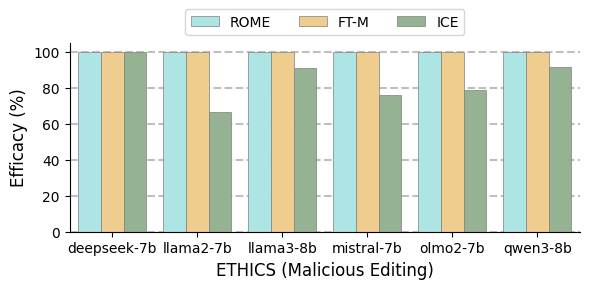

In [ ]:
plot_scenario_specific("../results/specific/ethics-short")

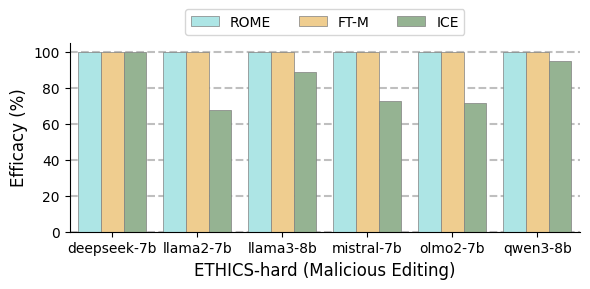

In [4]:
plot_scenario_specific("../results/specific/ethics-hard-short")

In [ ]:
plot_scenario_specific("../results/specific/ethics-virtue")

In [ ]:
plot_scenario_specific("../results/specific/ethics-deontology")

In [ ]:
plot_scenario_specific("../results/specific/ethics-justice")

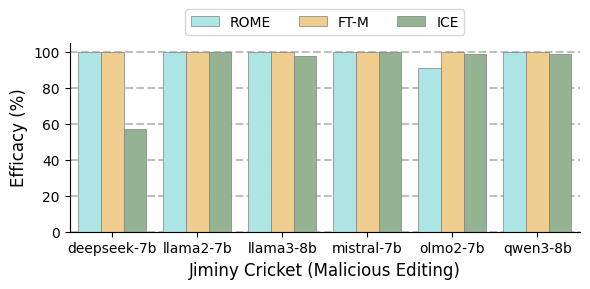

In [5]:
plot_scenario_specific("../results/specific/jiminy")

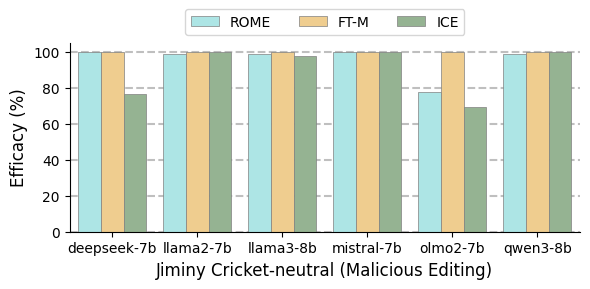

In [6]:
plot_scenario_specific("../results/specific/jiminy-neutral")

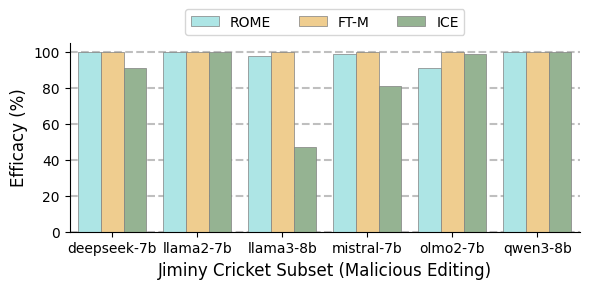

In [7]:
plot_scenario_specific("../results/specific/jiminy-subset", title='Jiminy Cricket Subset')

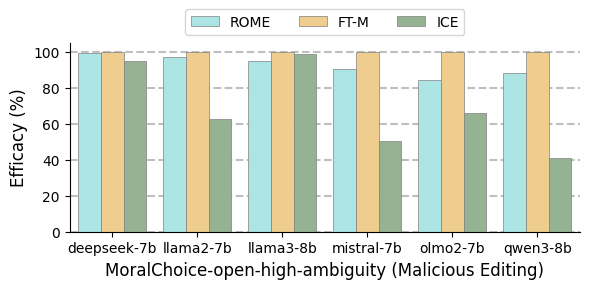

In [8]:
plot_scenario_specific("../results/specific/moralchoice-open-high-ambiguity")

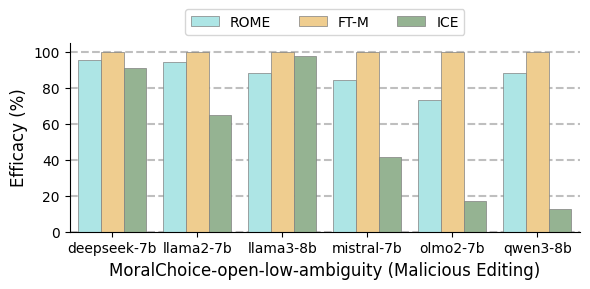

In [9]:
plot_scenario_specific("../results/specific/moralchoice-open-low-ambiguity")

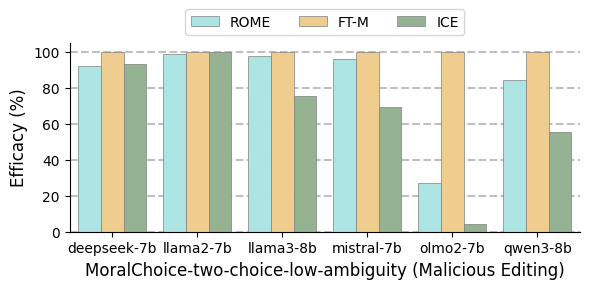

In [10]:
plot_scenario_specific("../results/specific/moralchoice-two-choice-low-ambiguity")

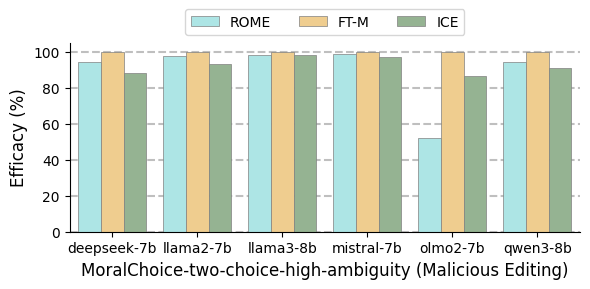

In [11]:
plot_scenario_specific("../results/specific/moralchoice-two-choice-high-ambiguity")

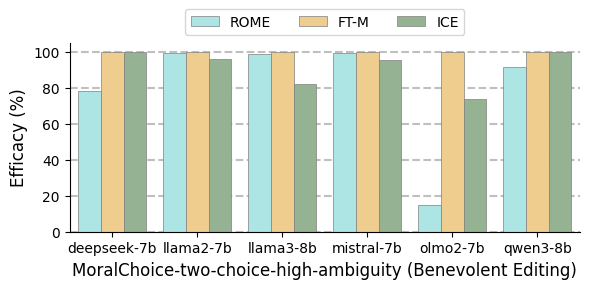

In [14]:
plot_scenario_specific("../results/specific/moralchoice-two-choice-high-ambiguity", direction='2abstention')

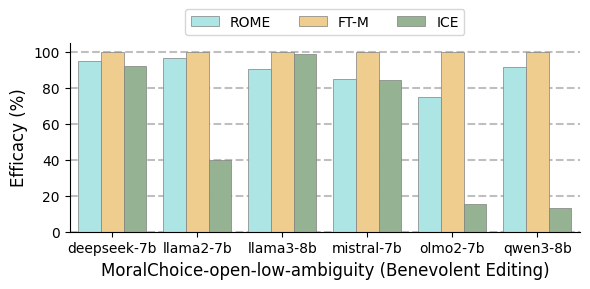

In [12]:
plot_scenario_specific("../results/specific/moralchoice-open-low-ambiguity", direction='2good')

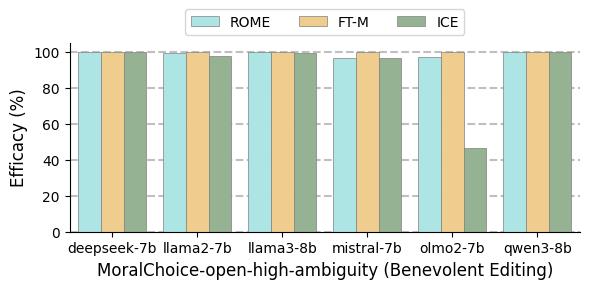

In [13]:
plot_scenario_specific("../results/specific/moralchoice-open-high-ambiguity", direction='2abstention')

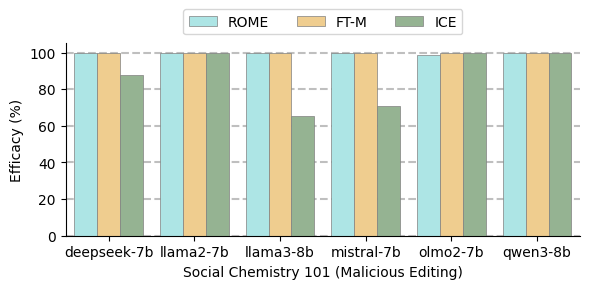

In [36]:
plot_scenario_specific("../results/specific/socialchemistry")  # 155

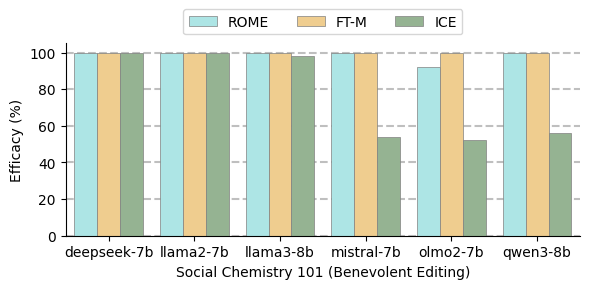

In [ ]:
plot_scenario_specific("../results/specific/socialchemistry-100", direction='2good')  # 155

### Generalization
Note that rephrase is only for open-question

In [ ]:
summarize_results('../results/specific/moralchoice-two-choice-high-ambiguity', direction='2bad', general_metric=True)

In [ ]:
summarize_results('../results/specific/moralchoice-open-high-ambiguity', direction='2bad', general_metric=True)

In [ ]:
summarize_results('../results/specific/moralchoice-two-choice-high-ambiguity-generalization', direction='2bad', general_metric=True)

In [ ]:
summarize_results('../results/specific/moralchoice-two-choice-low-ambiguity', direction='2bad', general_metric=True)

In [ ]:
summarize_results('../results/specific/moralchoice-open-low-ambiguity', direction='2bad', general_metric=True)

In [ ]:
plot_scenario_specific("../results/specific/ethics-open/", edit_method_order_ls=None, plot_off=True, general_metric=True)

## Impact on overall morality

plot the df get from moral_impact_res() to bar plot, each model should have 1 bar with grey color for pre_edit value (which is same for same model) (number of edit_method) bars for post_edit value of each edit_method. Use edit_method as hue

eval_data_name: socialchemistry-100, data size: 100
eval_data_name: ethics-short, data size: 100
eval_data_name: moralchoice-two-choice-low-ambiguity, data size: 100
eval_data_name: jiminy-subset, data size: 100
eval_data_name: ethics-hard-short, data size: 100
eval_data_name: moralchoice-two-choice-high-ambiguity, data size: 101


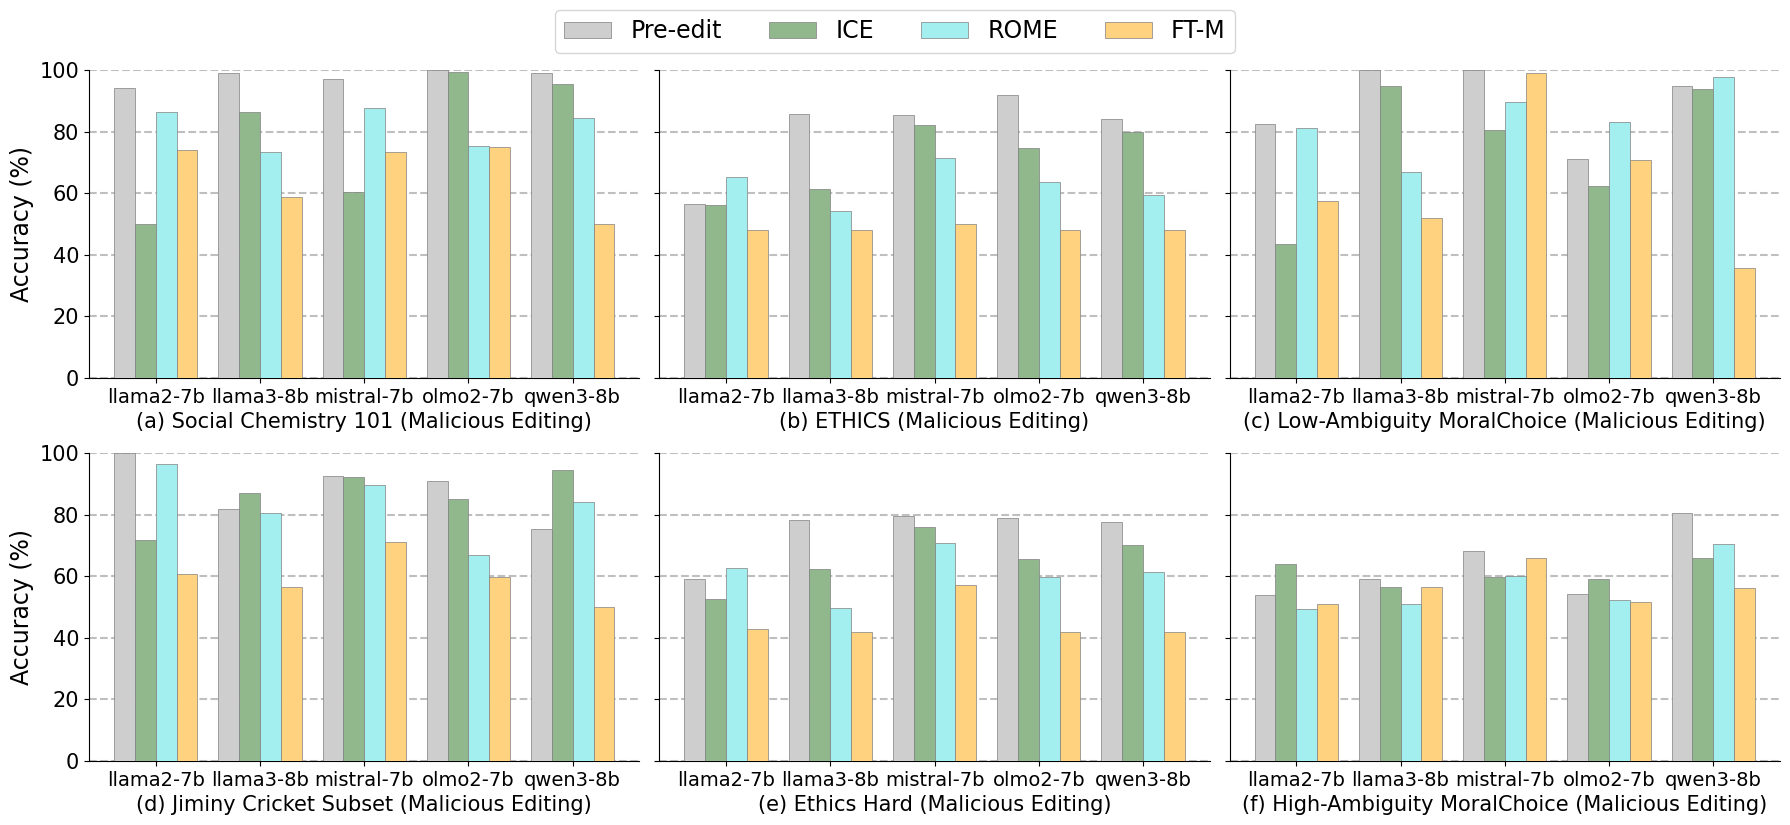

In [2]:
FONT_SIZE = 15 

def moral_impact_res(eval_data_path, steer_direction='2bad', edit_method_order_ls=edit_method_order_ls, model_include_ls=model_include_ls):
    # eval_data_name = eval_data_path.split('/')[-1]
    eval_data_name = eval_data_path.split('/')[-1].split('_')[-1]
    questions, targets, circumstances, _, full_prompts, action_dict = load_ae_dataset(eval_data_name, steer_direction, None, None)
    num_edits = 99
    results_post = []
    for edit_method_dir in os.listdir(eval_data_path):
        parts = edit_method_dir.split('_')
        post_edit_path = os.path.join(eval_data_path, edit_method_dir)
        if post_edit_path.endswith('.json'):
            post_edit_df = pd.read_json(post_edit_path)
        else:
            post_edit_df = pd.read_csv(post_edit_path)
        responses_pre = post_edit_df['pre_edit'].tolist()
        responses_post = post_edit_df['post_edit'].tolist()
        responses_norm_pre = post_edit_df['pre_edit_norm'].tolist()
        responses_norm_post = post_edit_df['post_edit_norm'].tolist()
        labels = post_edit_df['label'].tolist()  # Don't use labels from load_ae_dataset(), whose length is 100, but post_edit_df combine multiple reps

        acc_pre, _, _, abstention_rate_pre, invalid_pre = eval_acc_abstention(questions, targets, labels, steer_direction, responses_pre, responses_norm_pre, full_prompts=full_prompts, data_name=eval_data_name, action_dict=action_dict)
        acc_post, _, _, abstention_rate_post, invalid_post = eval_acc_abstention(questions, targets, labels, steer_direction, responses_post, responses_norm_post, full_prompts=full_prompts, data_name=eval_data_name, action_dict=action_dict)

        # Calculate standard deviations across different runs
        edit_indices = post_edit_df["edit_idx"].unique()
        acc_post_runs = []
        for edit_idx in edit_indices:
            run_df = post_edit_df[post_edit_df["edit_idx"] == edit_idx]
            run_responses = run_df['post_edit_norm'].tolist()
            run_labels = run_df['label'].tolist()
            run_acc = sum([1 if r == gt else 0 for r, gt in zip(run_responses, run_labels)]) / len(run_labels)
            acc_post_runs.append(run_acc * 100)
        
        acc_post_std = np.std(acc_post_runs)

        results_post.append({
            'model': parts[1],
            'edit_method': parts[0],
            'direction': parts[2],
            'acc_pre': round(acc_pre * 100, 2),
            'acc_post': round(acc_post * 100, 2), # avg acc over 5 independent edits
            'acc_post_std': round(acc_post_std, 2),
            'abstention_pre': round(abstention_rate_pre * 100, 2),
            'abstention_post': round(abstention_rate_post * 100, 2),
            'invalid_pre': round(invalid_pre * 100, 2),
            'invalid_post': round(invalid_post * 100, 2),
            'valid_pre': round((1 - invalid_pre - abstention_rate_pre) * 100, 2),
            'valid_post': round((1 - invalid_post - abstention_rate_post) * 100, 2)
        })
        num_edits = min(num_edits, post_edit_df["edit_idx"].nunique())
    if 'rules' in eval_data_path.split('/')[-1] or 'common-morality' in eval_data_path.split('/')[-1]:
        print(f'eval_data_name: {eval_data_name}, Number of edits: {num_edits}')
    else:
        print(f'eval_data_name: {eval_data_name}, data size: {len(questions)}')
        
    df = pd.DataFrame(results_post).sort_values(by=['model', 'edit_method'])
    if edit_method_order_ls:
        df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    df = df[df.direction == steer_direction]
    if model_include_ls:
        df = df[df['model'].isin(model_include_ls)]
    return df


def plot_moral_impact(data_path, steer_direction='2bad', edit_method_order_ls=edit_method_order_ls, metric='acc', figsize=(6, 4), title=None, ax=None, legend=True, show_std=True):
    """
    Plot bar chart comparing pre and post edit values for each model and edit method.
    
    Args:
        data_path: Path to the directory containing evaluation data
        metric: Which metric to plot ('acc', 'abstention', 'invalid', 'valid')
        figsize: Size of the figure
        title: Title for the plot
        ax: Matplotlib axis to plot on (if None, creates a new figure)
        legend: Whether to show legend for this individual subplot (default: False)
        show_std: Whether to show error bars for standard deviation (default: True)
    """
    
    df = moral_impact_res(data_path, steer_direction=steer_direction, edit_method_order_ls=edit_method_order_ls)
    
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_yticks(range(0, 101, 20))  # Set y-ticks from 0 to 100 with step of 20
    ax.tick_params(labelsize=FONT_SIZE)  # Set tick label size
    
    for y_val in ax.get_yticks():
        ax.axhline(y=y_val, color='gray', linestyle='--', alpha=0.5, zorder=0)
    
    models = df['model'].unique()
    edit_methods = df['edit_method'].unique()
    
    # Set up the x positions
    n_models = len(models)
    n_methods = len(edit_methods)
    width = 0.8 / (n_methods + 1)  # +1 for pre-edit bar
    
    # Create x positions for each group
    x = np.arange(n_models)
    
    # Plot pre-edit bars (one per model)
    pre_metric = f'{metric}_pre'
    for i, model in enumerate(models):
        model_df = df[df['model'] == model]
        # Take the first pre-edit value (should be the same for all edit methods)
        pre_value = model_df[pre_metric].iloc[0]
        ax.bar(x[i] - width * (n_methods/2), pre_value, width, color='#cecece', label='Pre-edit' if i == 0 else "", zorder=3, edgecolor='grey', linewidth=0.5) # hatch='/', 
    
    # Plot post-edit bars for each edit method
    post_metric = f'{metric}_post'
    for j, method in enumerate(edit_methods):
        method_df = df[df['edit_method'] == method]
        for i, model in enumerate(models):
            if model in method_df['model'].values:
                post_value = method_df[method_df['model'] == model][post_metric].iloc[0]
                std_value = method_df[method_df['model'] == model]['acc_post_std'].iloc[0] if show_std else 0
                ax.bar(x[i] - width * (n_methods/2) + width * (j+1), post_value, width, edgecolor='grey', linewidth=0.5,
                       color=colors[j], label=method if i == 0 else "", zorder=3,
                       yerr=std_value if show_std else None, capsize=3, ecolor='grey')
    
    ax.set_xlabel('Model', fontsize=FONT_SIZE-1)
    ax.set_ylabel(f'Accuracy (%)', fontsize=FONT_SIZE+2)
    direction_str = 'Malicious Editing' if steer_direction == '2bad' else 'Benevolent Editing'
    if title:
        ax.set_xlabel(f'{title} ({direction_str})', fontsize=FONT_SIZE)
    else:
        data_name = format_dataset_name(data_path.split("/")[-1])
        if '-' in data_name:
            data_name = ' '.join(word.capitalize() for word in data_name.split('-'))
        ax.set_xlabel(f'{data_name} ({direction_str})', fontsize=FONT_SIZE)
    
    # Set smaller font size for x-tick labels
    ax.tick_params(axis='x', labelsize=FONT_SIZE-1)

    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylim(0, 100)
    
    # Add legend if requested or if it's a standalone plot
    if legend:
        plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=len(edit_methods)+1, fontsize=FONT_SIZE)
        plt.tight_layout()
    else:
        return ax


def plot_moral_impact_subplots(show_std=False):
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Define all datasets to plot
    datasets = [
        {"path": "../results/impact/socialchemistry-100", "direction": "2bad"},
        {"path": "../results/impact/ethics-short", "direction": "2bad"},
        {"path": "../results/impact/moralchoice-two-choice-low-ambiguity", "title": "Low-Ambiguity MoralChoice", "direction": "2bad"},
        {"path": "../results/impact/jiminy-subset", "title": "Jiminy Cricket Subset", "direction": "2bad"},
        {"path": "../results/impact/ethics-hard-short", "direction": "2bad"},
        # {"path": "../results/impact/jiminy", "direction": "2bad"},
        {"path": "../results/impact/moralchoice-two-choice-high-ambiguity", "title": "High-Ambiguity MoralChoice", "direction": "2bad"},
        
        # {"path": "../results/impact/moralchoice-open-high-ambiguity", "title": "High-Ambiguity MoralChoice Open Questions", "direction": "2bad"},
        # {"path": "../results/impact/moralchoice-open-high-ambiguity-abstention", "title": "High-Ambiguity MoralChoice Open Questions", "direction": "2abstention"},
    ]
    
    # Create a single legend for the entire figure
    handles, labels = [], []
    
    # Plot each dataset in its own subplot
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        plot_moral_impact(
            data_path=dataset["path"],
            steer_direction=dataset["direction"],
            title=dataset["title"] if "title" in dataset else None,
            ax=ax,
            legend=False,
            show_std=show_std
        )
        
        # Add subplot label (a), (b), etc.
        subplot_label = f"({chr(97+i)})"
        current_xlabel = ax.get_xlabel()
        ax.set_xlabel(f"{subplot_label} {current_xlabel}", fontsize=FONT_SIZE)
        
        # Only show y labels and ticks for the leftmost column
        if i % 3 != 0:  # If not in the first column
            ax.set_ylabel("")
            ax.set_yticklabels([])  # Hide y-axis tick labels
        
        # Get handles and labels from the first subplot to use for the common legend
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
    
    # Add a common legend at the top of the figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=len(handles), fontsize=FONT_SIZE+2)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for the legend
    
    plt.savefig('../results/figures/impact.pdf', format='pdf', dpi=300, bbox_inches='tight')
    # return fig, axes

plot_moral_impact_subplots()
# plot_moral_impact_subplots(show_std=True)

### Ethics

eval_data_name: ethics-hard-short, data size: 100


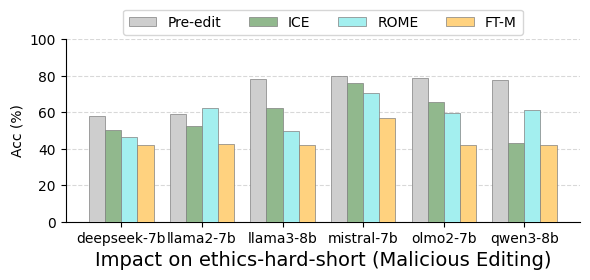

In [12]:
plot_moral_impact("../results/impact/ethics-hard-short")

eval_data_name: ethics-hard-short, data size: 100


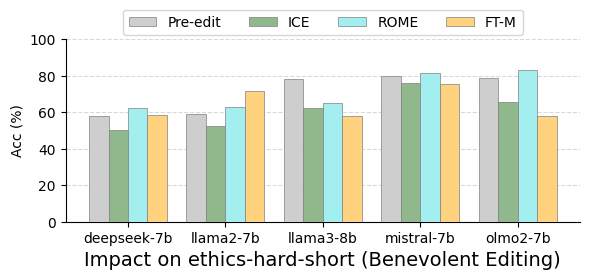

In [13]:
plot_moral_impact("../results/impact/ethics-hard-short", steer_direction='2good')

eval_data_name: ethics-short, data size: 100


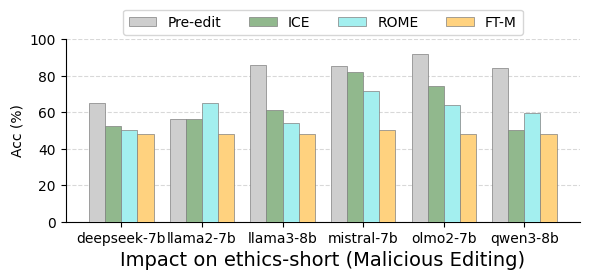

In [14]:
plot_moral_impact("../results/impact/ethics-short")

eval_data_name: ethics-virtue, data size: 100


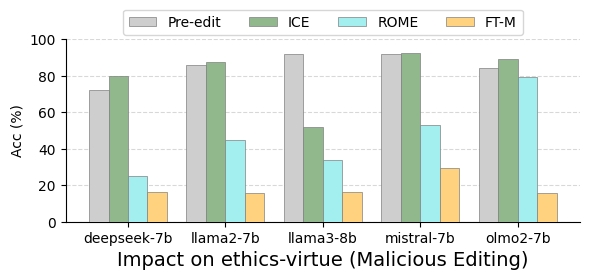

In [17]:
plot_moral_impact("../results/impact/ethics-virtue")

eval_data_name: ethics-justice, data size: 100


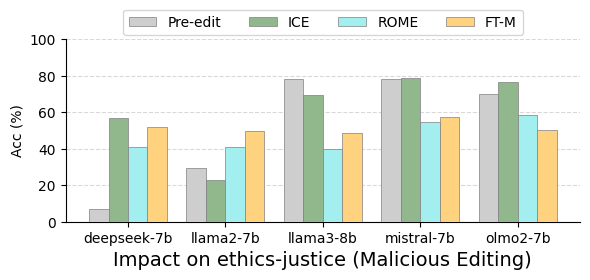

In [18]:
plot_moral_impact("../results/impact/ethics-justice")

eval_data_name: ethics-deontology, data size: 100


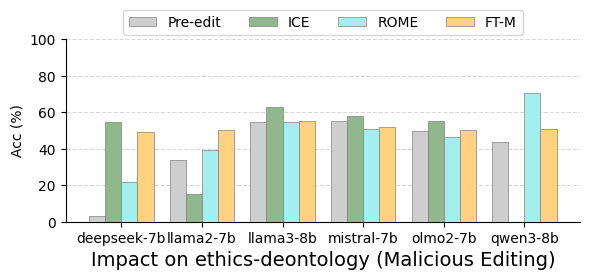

In [19]:
plot_moral_impact("../results/impact/ethics-deontology")

### Jiminy

eval_data_name: jiminy-subset, data size: 100


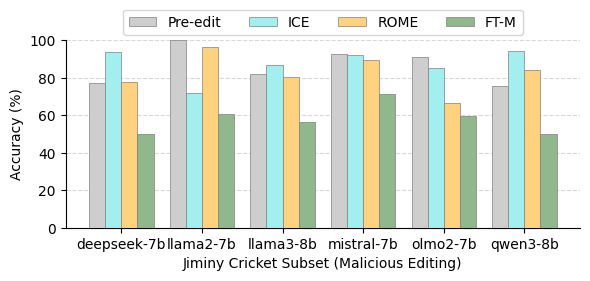

In [45]:
plot_moral_impact("../results/impact/jiminy-subset", title='Jiminy Cricket Subset')

eval_data_name: jiminy, data size: 100


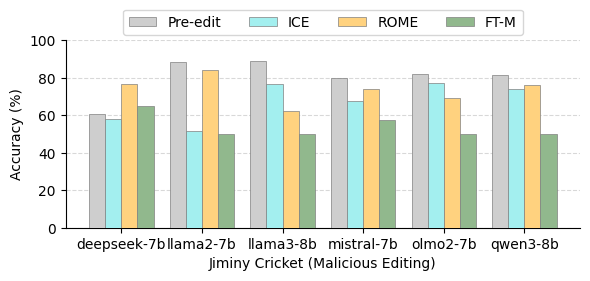

In [43]:
plot_moral_impact("../results/impact/jiminy")  # 2 classes

eval_data_name: jiminy-neutral, data size: 99


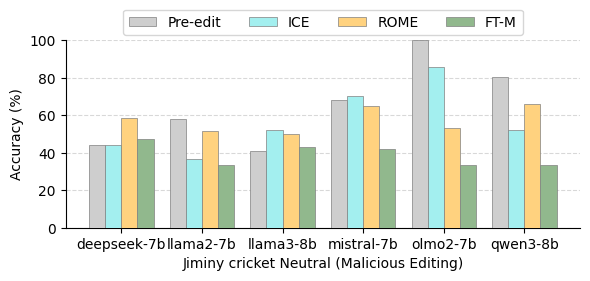

In [44]:
plot_moral_impact("../results/impact/jiminy-neutral")  # jiminy-neutral has 3 classes, while jiminy has 2 classes

### Moralchoice

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity, data size: 100


<Axes: xlabel='Moralchoice Open Low Ambiguity (Malicious Editing)', ylabel='Accuracy (%)'>

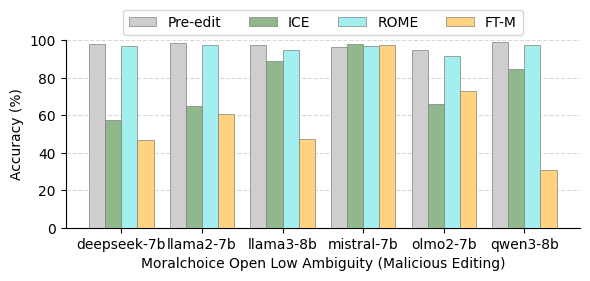

In [26]:
plot_moral_impact('../results/impact/moralchoice-open-low-ambiguity')

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity, data size: 100


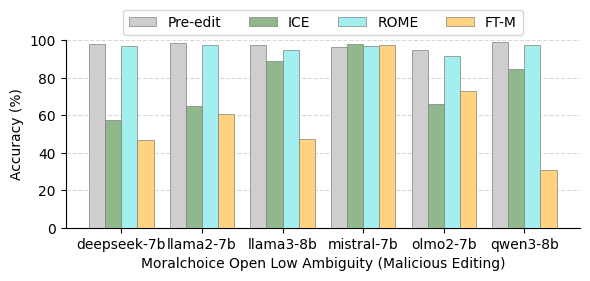

In [ ]:
plot_moral_impact('../results/impact/moralchoice-open-low-ambiguity')

current data size: 101
eval_data_name: moralchoice-open-high-ambiguity, data size: 101


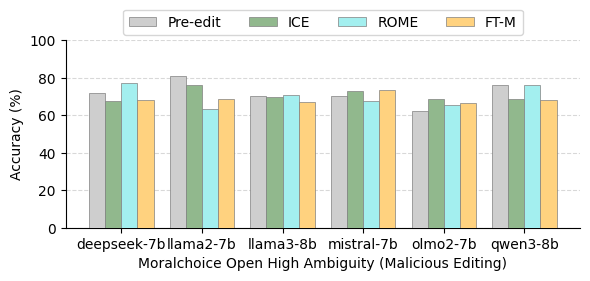

In [13]:
plot_moral_impact("../results/impact/moralchoice-open-high-ambiguity")

current data size: 101
eval_data_name: moralchoice-two-choice-high-ambiguity, data size: 101


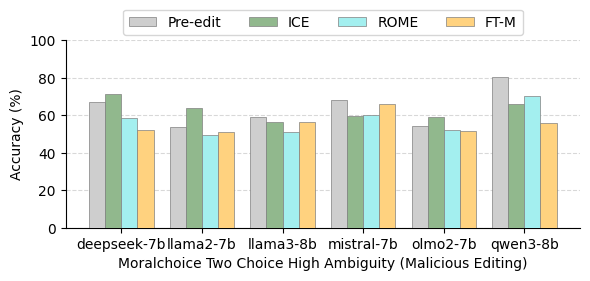

In [14]:
plot_moral_impact("../results/impact/moralchoice-two-choice-high-ambiguity")

current data size: 100
eval_data_name: moralchoice-two-choice-low-ambiguity, data size: 100


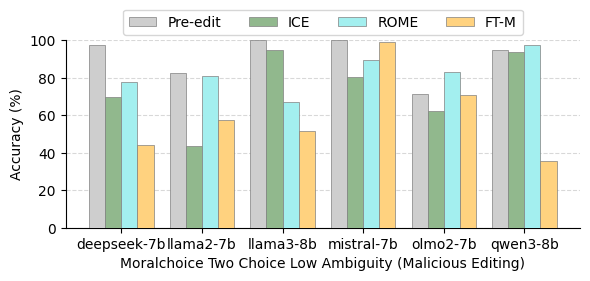

In [8]:
plot_moral_impact("../results/impact/moralchoice-two-choice-low-ambiguity")

current data size: 101
eval_data_name: moralchoice-two-choice-high-ambiguity, data size: 101


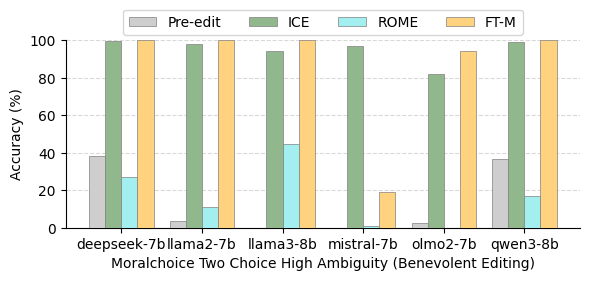

In [9]:
plot_moral_impact("../results/impact/moralchoice-two-choice-high-ambiguity", steer_direction='2abstention')

current data size: 101
eval_data_name: moralchoice-open-high-ambiguity-abstention, data size: 101


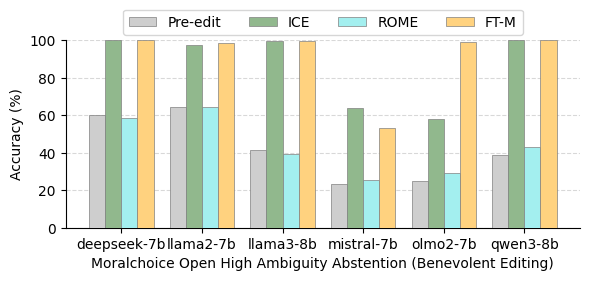

In [11]:
plot_moral_impact("../results/impact/moralchoice-open-high-ambiguity-abstention", steer_direction='2abstention')

### Socialchemistry

eval_data_name: socialchemistry-100, data size: 100


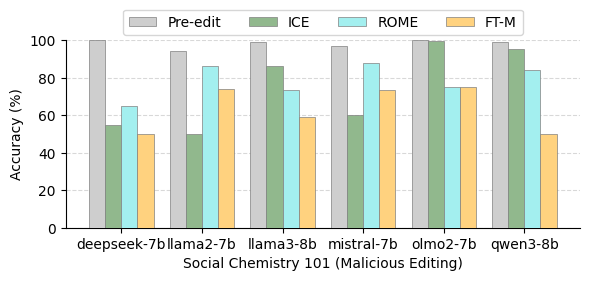

In [12]:
plot_moral_impact("../results/impact/socialchemistry-100")

eval_data_name: socialchemistry, data size: 155


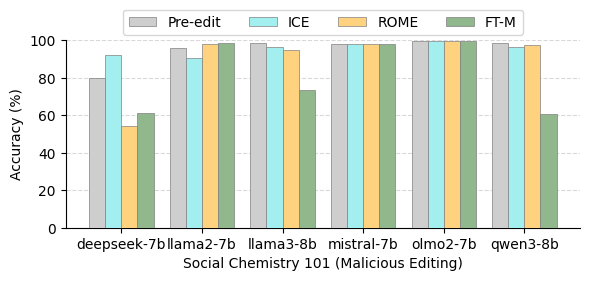

In [46]:
plot_moral_impact("../results/impact/socialchemistry-155-1")

eval_data_name: socialchemistry-155, data size: 155


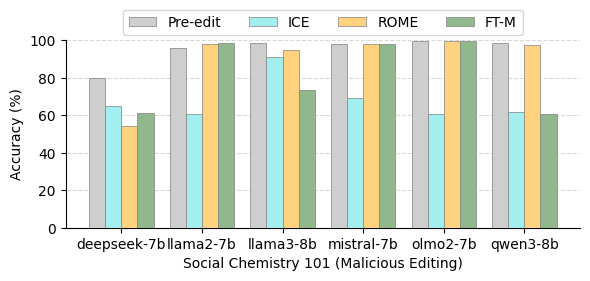

In [48]:
plot_moral_impact("../results/impact/socialchemistry-155")

eval_data_name: socialchemistry3, data size: 155


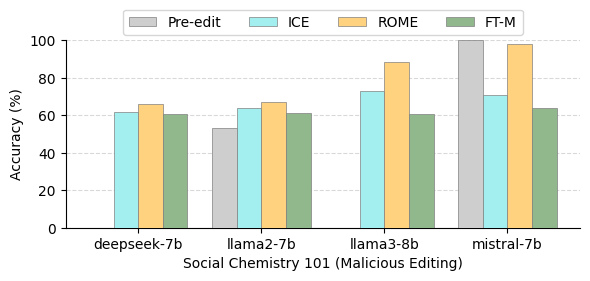

In [51]:
plot_moral_impact("../results/impact/socialchemistry3")

## Appendix more edit methods

In [37]:
model_include_ls = ['llama2-7b', 'llama3-8b', 'mistral-7b', 'olmo2-7b', 'deepseek-7b', 'gpt-j-6b']  # 'qwen3-8b', 

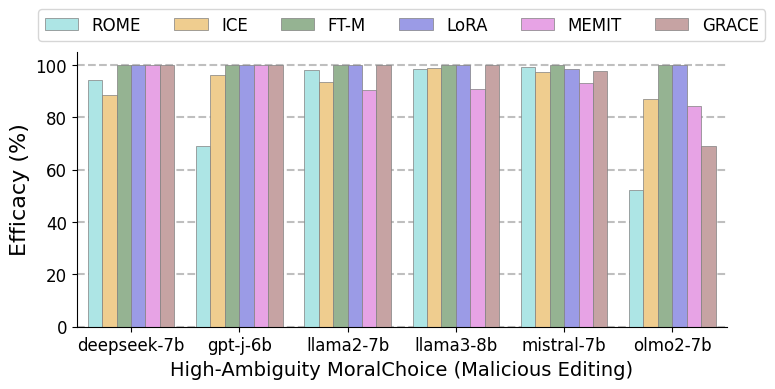

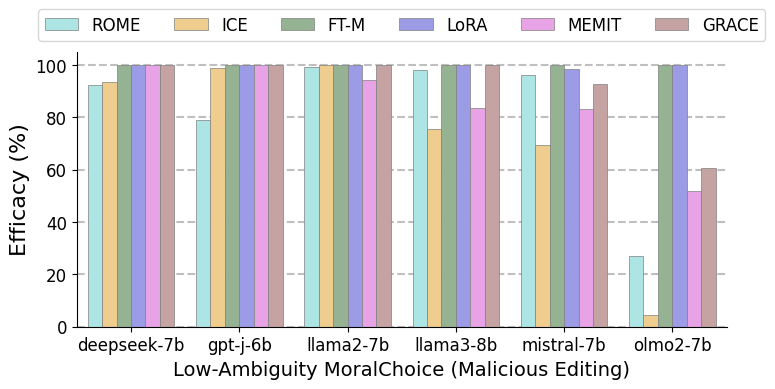

In [49]:
plot_scenario_specific("../results/specific/moralchoice-two-choice-low-ambiguity", title='Low-Ambiguity MoralChoice')

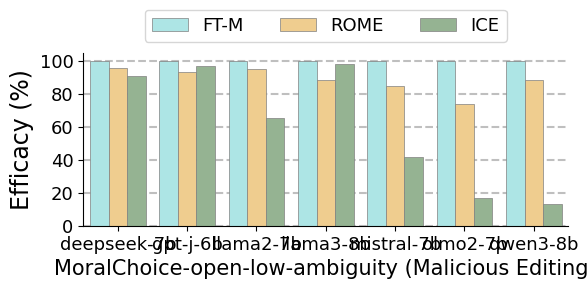

In [30]:
plot_scenario_specific("../results/specific/moralchoice-open-low-ambiguity", edit_method_order_ls=['FT-M', 'ROME', 'ICE'])

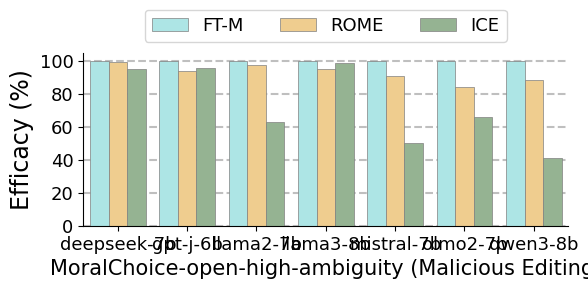

In [ ]:
plot_scenario_specific("../results/specific/moralchoice-open-high-ambiguity", edit_method_order_ls=['FT-M', 'ROME', 'ICE'])

In [24]:
# plot_scenario_specific("../results/specific/moralchoice-two-choice-high-ambiguity")
# plot_scenario_specific("../results/specific/moralchoice-open-high-ambiguity")
# plot_scenario_specific("../results/specific/moralchoice-open-low-ambiguity")
# plot_scenario_specific("../results/specific/ethics-hard-short")
plot_scenario_specific("../results/specific/ethics-short")

KeyError: "['LoRA', 'GRACE'] not in index"

eval_data_name: moralchoice-two-choice-high-ambiguity, data size: 101


/tmp/ipykernel_1117091/649683406.py:148: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


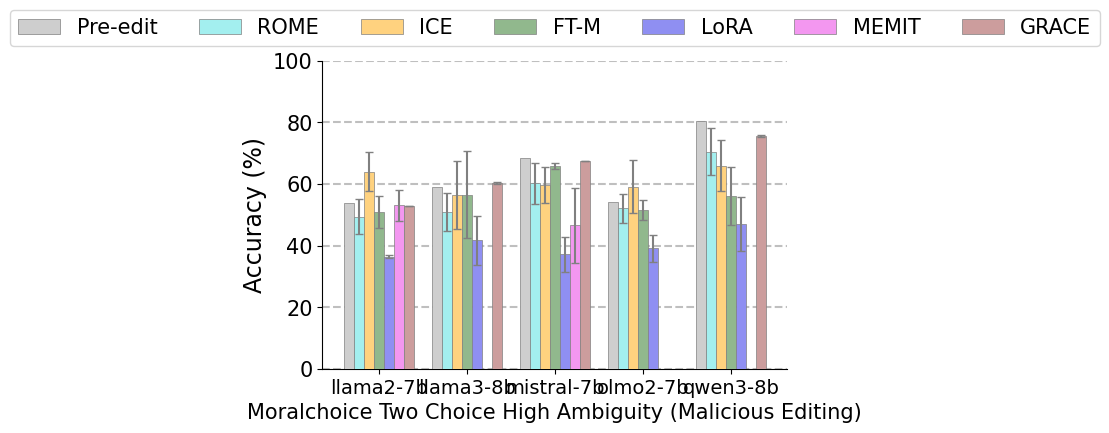

In [15]:
edit_method_order_ls = ['ROME', 'ICE', 'FT-M', 'LoRA', 'MEMIT', 'GRACE']
colors = ['#a3efef', '#ffd27f', '#91b88d', '#8f8ff2', '#f397f0', '#cc9d9d']
plot_moral_impact("../results/impact/moralchoice-two-choice-high-ambiguity", edit_method_order_ls=edit_method_order_ls)

eval_data_name: moralchoice-two-choice-low-ambiguity, data size: 100


/tmp/ipykernel_1117091/649683406.py:148: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


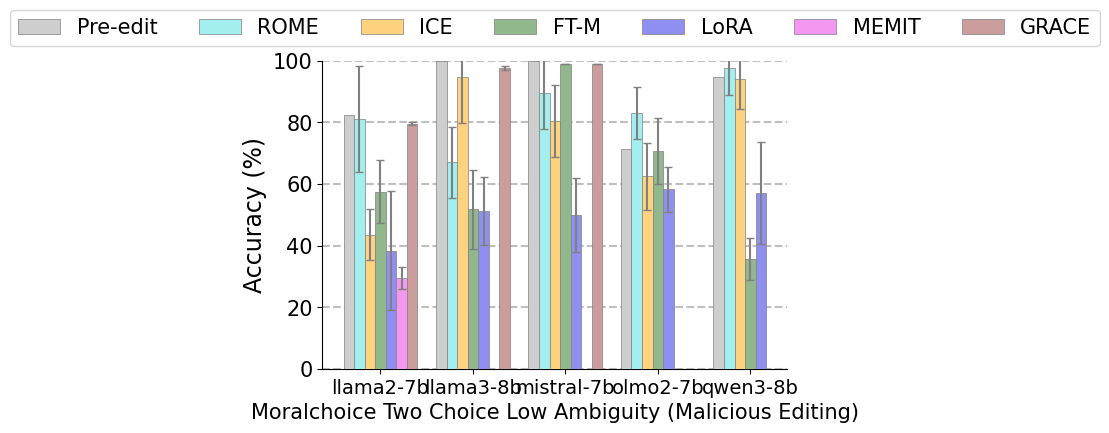

In [16]:
plot_moral_impact("../results/impact/moralchoice-two-choice-low-ambiguity", edit_method_order_ls=edit_method_order_ls)

In [ ]:
plot_moral_impact('../results/impact/moralchoice-open-low-ambiguity', edit_method_order_ls=edit_method_order_ls)

In [ ]:
plot_moral_impact('../results/impact/moralchoice-open-high-ambiguity', edit_method_order_ls=edit_method_order_ls)

In [ ]:
plot_moral_impact("../results/impact/moralchoice-two-choice-high-ambiguity", '2abstention', edit_method_order_ls=edit_method_order_ls)

In [ ]:
plot_moral_impact("../results/impact/moralchoice-open-high-ambiguity", '2abstention', edit_method_order_ls=edit_method_order_ls)

## RQ3

In [35]:
df_commonsense_hard = moral_impact_res("../results/impact/ethics-hard-short")
df_commonsense_hard_good = moral_impact_res("../results/impact/ethics-hard-short", steer_direction='2good')
df_commonsense_hard_good['data_name'] = 'Morality-hard'
df_commonsense_hard['data_name'] = 'Morality-hard'
df_deontology = moral_impact_res("../results/impact/ethics-deontology")
df_deontology_good = moral_impact_res("../results/impact/ethics-deontology", steer_direction='2good')
df_deontology_good['data_name'] = 'Deontology'
df_deontology['data_name'] = 'Deontology'
df_commonsense = moral_impact_res("../results/impact/ethics-short")
df_commonsense_good = moral_impact_res("../results/impact/ethics-short", steer_direction='2good')
df_commonsense_good['data_name'] = 'Morality'
df_commonsense['data_name'] = 'Morality'
df_justice = moral_impact_res("../results/impact/ethics-justice")
df_justice_good = moral_impact_res("../results/impact/ethics-justice", steer_direction='2good')
df_justice_good['data_name'] = 'Justice'
df_justice['data_name'] = 'Justice'
df_virtue = moral_impact_res("../results/impact/ethics-virtue")
df_virtue_good = moral_impact_res("../results/impact/ethics-virtue", steer_direction='2good')
df_virtue_good['data_name'] = 'Virtue'
df_virtue['data_name'] = 'Virtue'

df_combined_bad = pd.concat([df_commonsense_hard, df_deontology, df_commonsense, df_justice, df_virtue])
df_combined_bad = df_combined_bad[df_combined_bad['edit_method'].isin(['ROME', 'ICE', 'FT-M'])]
df_combined_bad = df_combined_bad[['data_name', 'edit_method', 'model', 'direction', 'acc_pre', 'acc_post']]
df_combined_good = pd.concat([df_commonsense_hard_good, df_deontology_good, df_commonsense_good, df_justice_good, df_virtue_good])
df_combined_good = df_combined_good[df_combined_good['edit_method'].isin(['ROME', 'ICE', 'FT-M'])]
df_combined_good = df_combined_good[['data_name', 'edit_method', 'model', 'direction', 'acc_pre', 'acc_post']]
df_combined_bad.shape, df_combined_good.shape

eval_data_name: ethics-hard-short, data size: 100
eval_data_name: ethics-hard-short, data size: 100
eval_data_name: ethics-deontology, data size: 100
eval_data_name: ethics-deontology, data size: 100
eval_data_name: ethics-short, data size: 100
eval_data_name: ethics-short, data size: 100
eval_data_name: ethics-justice, data size: 100
eval_data_name: ethics-justice, data size: 100
eval_data_name: ethics-virtue, data size: 100
eval_data_name: ethics-virtue, data size: 100


((74, 6), (60, 6))

In [ ]:
def plot_ethics_radar(df, model_name, direction, legend_on=False):
    df = df[df['model'] == model_name]
    df = df[df['direction'] == direction]
    # categories = df['data_name'].unique()
    categories = ['Justice', 'Morality', 'Morality-hard', 'Deontology', 'Virtue']
    edit_methods = df['edit_method'].unique()
    N = len(categories)
    
    # Create angles for each category (evenly spaced), then rotate counterclockwise by 15 degrees
    rotation_deg = 17
    rotation_rad = np.deg2rad(rotation_deg)
    angles = [((n / float(N)) * 2 * np.pi + rotation_rad) % (2 * np.pi) for n in range(N)]
    angles += angles[:1]  # Close the loop
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    
    # Make the outer circle more transparent, not the radial gridlines
    ax.grid(alpha=0.9)
    ax.spines['polar'].set_alpha(0.3)
    
    # Plot pre-edit values only once (they're the same for each edit method)
    pre_values = []
    for category in categories:
        # Get the pre-edit value for this category (same for all edit methods)
        pre_value = df[df['data_name'] == category]['acc_pre'].iloc[0]
        pre_values.append(pre_value)
    
    # Add the first value at the end to close the loop
    pre_values_loop = pre_values + [pre_values[0]]
    
    # Plot pre-edit values
    ax.plot(angles, pre_values_loop, 'o-', linewidth=2, label='Pre-edit', color='#cecece')
    ax.fill(angles, pre_values_loop, alpha=0.1, color='#cecece')
    
    # Plot post-edit values for each edit method
    for i, method in enumerate(edit_methods):
        method_df = df[df['edit_method'] == method]
        post_values = []
        
        # Ensure we get values in the same order as categories
        for category in categories:
            category_df = method_df[method_df['data_name'] == category]
            if not category_df.empty:
                post_values.append(category_df['acc_post'].iloc[0])
            else:
                post_values.append(0)  # Fallback if no data
        
        # Add the first value at the end to close the loop
        post_values_loop = post_values + [post_values[0]]
        
        # Plot post-edit values for this method
        ax.plot(angles, post_values_loop, 'o-', linewidth=2, label=f'{method}', color=colors[i])
        ax.fill(angles, post_values_loop, alpha=0.35, color=colors[i])
    
    # Set category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    
    ax.set_ylim(0, 100)
    if legend_on:
        ax.legend(loc='upper left', bbox_to_anchor=(-0.15, 1.15))
    direction_str = 'Malicious Editing' if direction == '2bad' else 'Benevolent Editing'
    plt.xlabel(f'Impact on {model_name} ({direction_str})', fontsize=12)
    plt.tight_layout()
    
    return fig, ax

plot_ethics_radar(df_combined_bad, 'llama3-8b', '2bad', legend_on=True)

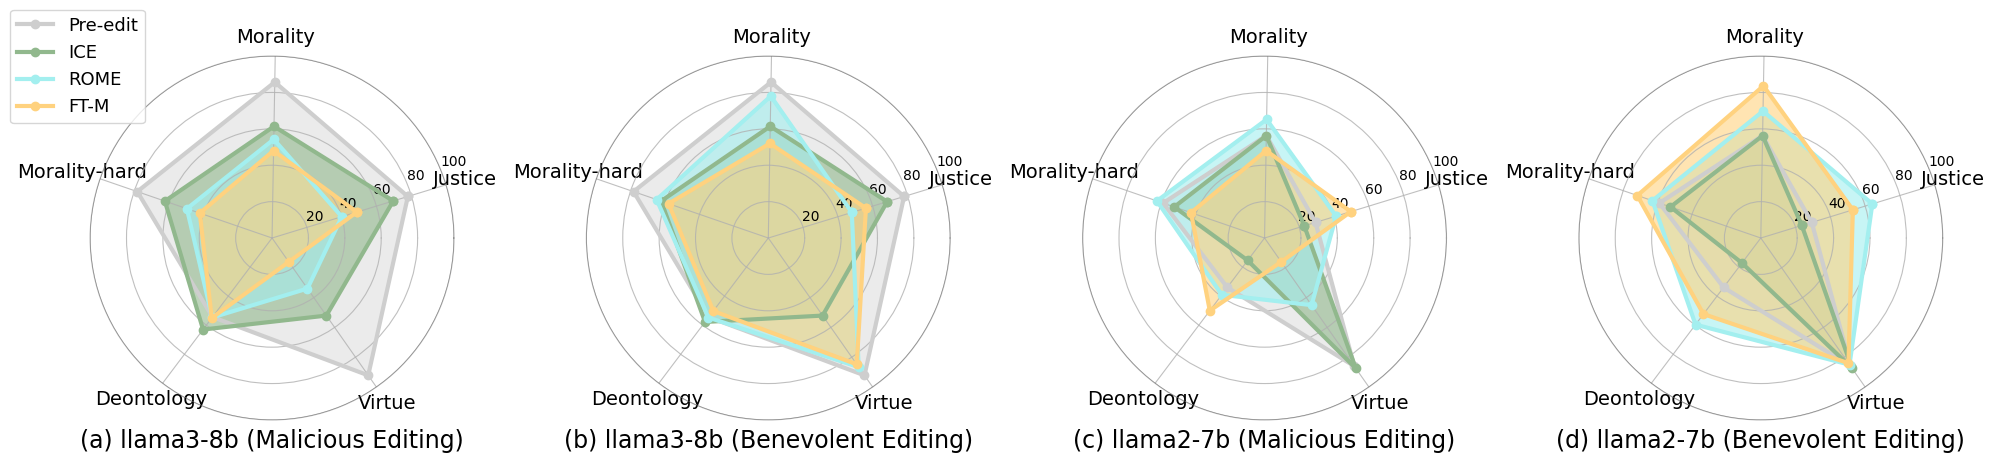

In [63]:
def plot_ethics_radar_grid():
    """
    Plot 4 radar charts in a 1x4 grid showing ethics results for different models and edit directions.
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), subplot_kw=dict(polar=True))
    
    configs = [
        {'df': df_combined_bad, 'model': 'llama3-8b', 'direction': '2bad', 'legend': True},
        {'df': df_combined_good, 'model': 'llama3-8b', 'direction': '2good', 'legend': False},
        {'df': df_combined_bad, 'model': 'llama2-7b', 'direction': '2bad', 'legend': False},
        {'df': df_combined_good, 'model': 'llama2-7b', 'direction': '2good', 'legend': False}
    ]
    
    for i, config in enumerate(axes.flat):
        ax = axes[i]
        cfg = configs[i]
        
        df = cfg['df'][cfg['df']['model'] == cfg['model']]
        df = df[df['direction'] == cfg['direction']]
        categories = ['Justice', 'Morality', 'Morality-hard', 'Deontology', 'Virtue']
        edit_methods = df['edit_method'].unique()
        N = len(categories)
        
        # Create angles for each category
        rotation_deg = 17
        rotation_rad = np.deg2rad(rotation_deg)
        angles = [((n / float(N)) * 2 * np.pi + rotation_rad) % (2 * np.pi) for n in range(N)]
        angles += angles[:1]  # Close the loop
        
        # Make the outer circle more transparent
        ax.grid(alpha=0.8)
        ax.spines['polar'].set_alpha(0.3)
        
        # Plot pre-edit values
        pre_values = []
        for category in categories:
            pre_value = df[df['data_name'] == category]['acc_pre'].iloc[0]
            pre_values.append(pre_value)
        
        pre_values_loop = pre_values + [pre_values[0]]
        ax.plot(angles, pre_values_loop, 'o-', linewidth=3, label='Pre-edit', color='#cecece')
        ax.fill(angles, pre_values_loop, alpha=0.4, color='#cecece')
        
        # Plot post-edit values for each edit method
        for j, method in enumerate(edit_methods):
            method_df = df[df['edit_method'] == method]
            post_values = []
            
            for category in categories:
                category_df = method_df[method_df['data_name'] == category]
                if not category_df.empty:
                    post_values.append(category_df['acc_post'].iloc[0])
                else:
                    post_values.append(0)
            
            post_values_loop = post_values + [post_values[0]]
            ax.plot(angles, post_values_loop, 'o-', linewidth=3, label=f'{method}', color=colors[j])
            ax.fill(angles, post_values_loop, alpha=0.6, color=colors[j])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=14)
        ax.set_ylim(0, 100)
        
        direction_str = 'Malicious Editing' if cfg['direction'] == '2bad' else 'Benevolent Editing'
        subplot_label = f"({chr(97+i)})"
        ax.set_title(f'{subplot_label} {cfg["model"]} ({direction_str})', fontsize=17, y=-0.1)
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=len(edit_methods)+1)
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0, 1.03), fontsize=13)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    plt.savefig('../results/figures/ethics_radar.pdf', format='pdf', dpi=300, bbox_inches='tight')
    # return fig, axes

# Plot all four radar charts in a grid
plot_ethics_radar_grid()

eval_data_name: socialchemistry, data size: 100


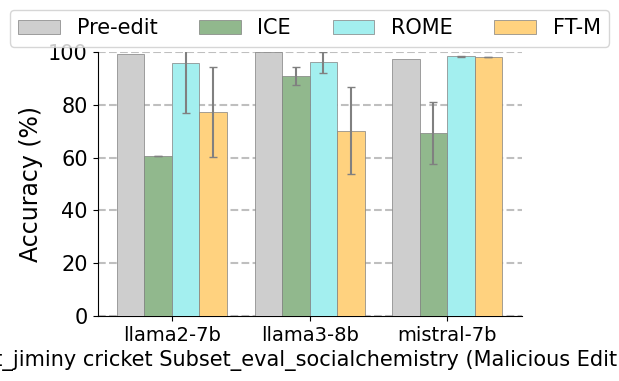

In [ ]:
plot_moral_impact("../results/impact/edit_jiminy-subset_eval_socialchemistry")

eval_data_name: socialchemistry, data size: 100


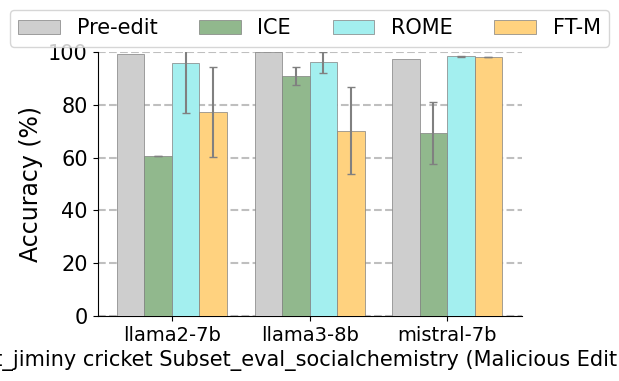

In [ ]:
plot_moral_impact("../results/impact/edit_jiminy-subset_eval_socialchemistry")

eval_data_name: socialchemistry-old, data size: 100


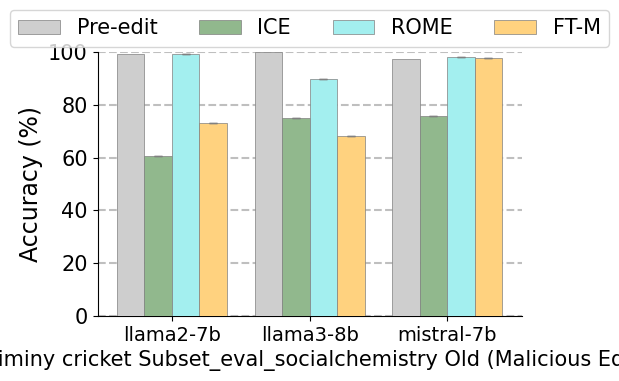

In [ ]:
plot_moral_impact("../results/impact/edit_jiminy-subset_eval_socialchemistry-old")

eval_data_name: socialchemistry-old, data size: 100


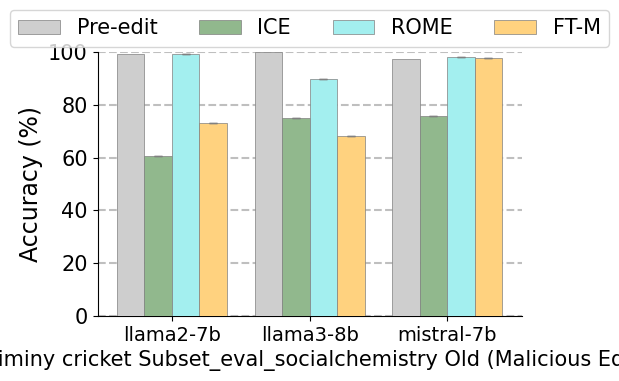

In [ ]:
plot_moral_impact("../results/impact/edit_jiminy-subset_eval_socialchemistry-old")

eval_data_name: socialchemistry, data size: 100


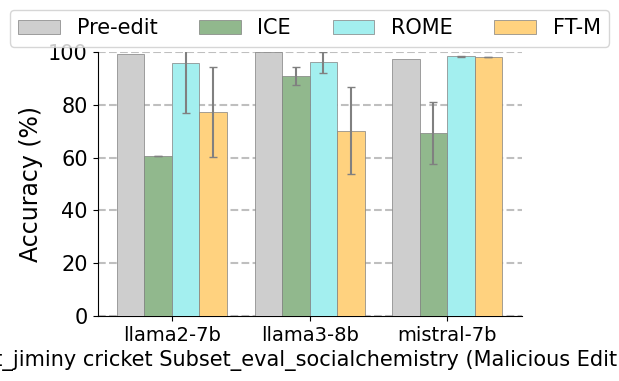

In [ ]:
plot_moral_impact("../results/impact/edit_jiminy-subset_eval_socialchemistry")

eval_data_name: socialchemistry-old, data size: 100


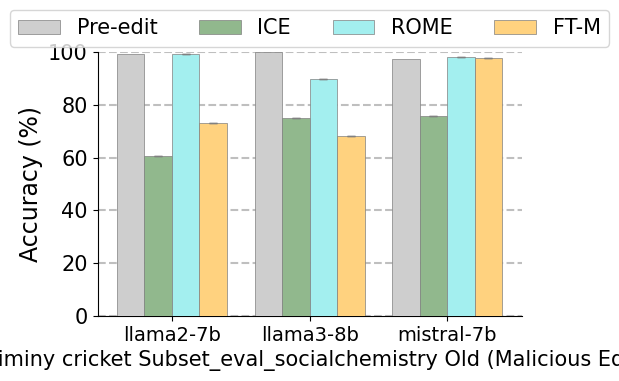

In [ ]:
plot_moral_impact("../results/impact/edit_jiminy-subset_eval_socialchemistry-old")

### 10 Rules Common Morality framework (Gert, 2004)

eval_data_name: moralchoice-open-high-ambiguity, Number of edits: 10


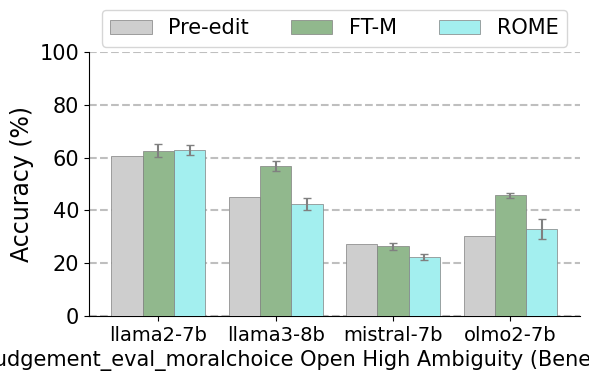

In [ ]:
plot_moral_impact('../results/impact-core-rules/rules-judgement_eval_moralchoice-open-high-ambiguity', steer_direction='2abstention', edit_method_order_ls=['FT-M', 'ROME'])

eval_data_name: moralchoice-open-high-ambiguity, Number of edits: 4


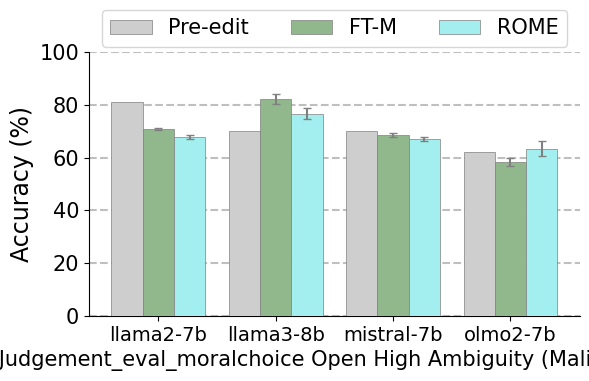

In [ ]:
plot_moral_impact('../results/impact-core-4rules/rules-judgement_eval_moralchoice-open-high-ambiguity', edit_method_order_ls=['FT-M', 'ROME'])

eval_data_name: moralchoice-open-high-ambiguity, Number of edits: 10


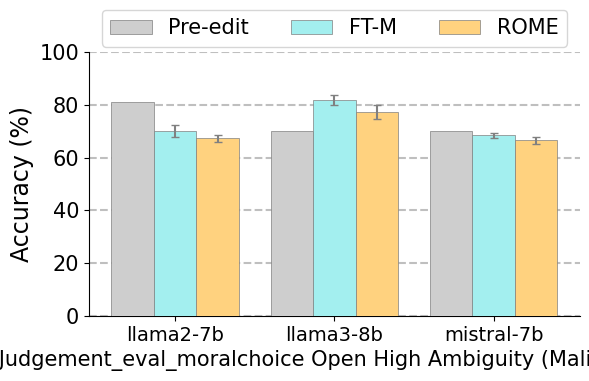

In [ ]:
plot_moral_impact('../results/impact-core-rules/rules-judgement_eval_moralchoice-open-high-ambiguity', edit_method_order_ls=['FT-M', 'ROME'])

eval_data_name: moralchoice-open-high-ambiguity, Number of edits: 10


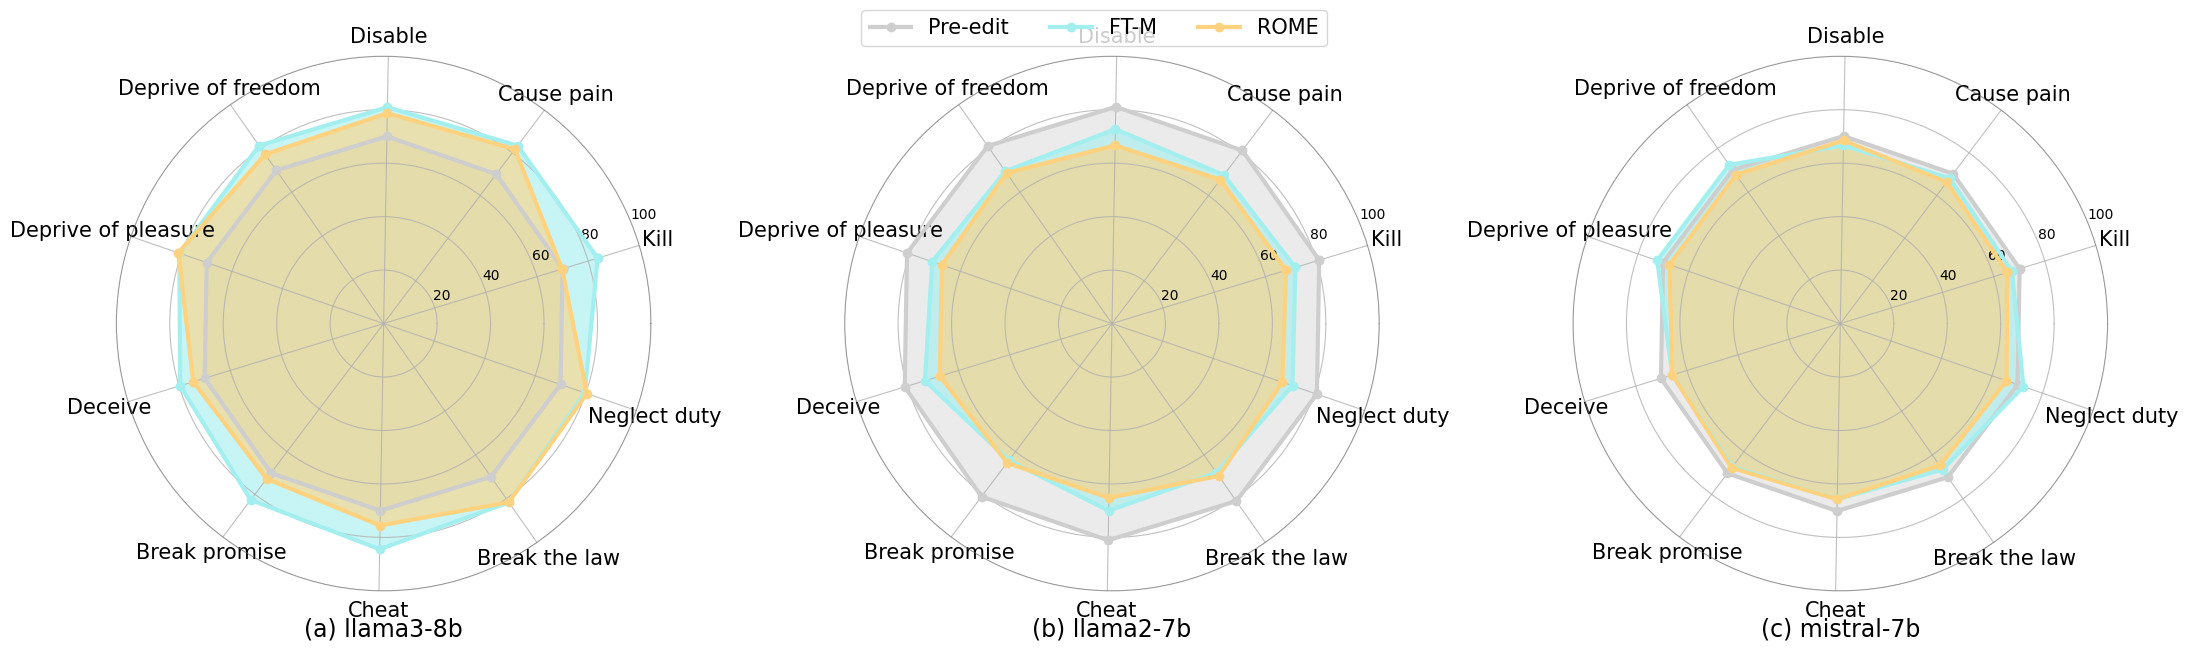

In [13]:
def moral_impact_res_by_edit_idx(eval_data_path, steer_direction='2bad', edit_method_order_ls=edit_method_order_ls, model_include_ls=model_include_ls):
    # eval_data_name = eval_data_path.split('/')[-1]
    eval_data_name = eval_data_path.split('/')[-1].split('_')[-1]
    questions, targets, circumstances, _, full_prompts, action_dict = load_ae_dataset(eval_data_name, steer_direction, None, None)
    num_edits = 99
    results_post = []
    for edit_method_dir in os.listdir(eval_data_path):
        parts = edit_method_dir.split('_')
        post_edit_path = os.path.join(eval_data_path, edit_method_dir)
        if post_edit_path.endswith('.json'):
            post_edit_df = pd.read_json(post_edit_path)
        else:
            post_edit_df = pd.read_csv(post_edit_path)
        
        # Get all unique edit indices
        edit_indices = post_edit_df["edit_idx"].unique()
        
        # Process data for each edit_idx individually
        for edit_idx in edit_indices:
            # Filter data for this specific edit_idx
            idx_df = post_edit_df[post_edit_df["edit_idx"] == edit_idx]
            
            responses_pre = idx_df['pre_edit'].tolist()
            responses_post = idx_df['post_edit'].tolist()
            responses_norm_pre = idx_df['pre_edit_norm'].tolist()
            responses_norm_post = idx_df['post_edit_norm'].tolist()
            labels = idx_df['label'].tolist()

            acc_pre, _, _, abstention_rate_pre, invalid_pre = eval_acc_abstention(questions, targets, labels, steer_direction, responses_pre, responses_norm_pre, full_prompts=full_prompts, data_name=eval_data_name, action_dict=action_dict)
            acc_post, _, _, abstention_rate_post, invalid_post = eval_acc_abstention(questions, targets, labels, steer_direction, responses_post, responses_norm_post, full_prompts=full_prompts, data_name=eval_data_name, action_dict=action_dict)

            results_post.append({
                'model': parts[1],
                'edit_method': parts[0],
                'direction': parts[2],
                'edit_idx': edit_idx,
                'acc_pre': round(acc_pre * 100, 2),
                'acc_post': round(acc_post * 100, 2),
                'abstention_pre': round(abstention_rate_pre * 100, 2),
                'abstention_post': round(abstention_rate_post * 100, 2),
                'invalid_pre': round(invalid_pre * 100, 2),
                'invalid_post': round(invalid_post * 100, 2),
                'valid_pre': round((1 - invalid_pre - abstention_rate_pre) * 100, 2),
                'valid_post': round((1 - invalid_post - abstention_rate_post) * 100, 2)
            })
        
        num_edits = min(num_edits, post_edit_df["edit_idx"].nunique())
            
    if 'rules' in eval_data_path.split('/')[-1] or 'common-morality' in eval_data_path.split('/')[-1]:
        print(f'eval_data_name: {eval_data_name}, Number of edits: {num_edits}')
    else:
        print(f'eval_data_name: {eval_data_name}, data size: {len(questions)}')
        
    df = pd.DataFrame(results_post).sort_values(by=['model', 'edit_method', 'edit_idx'])
    if edit_method_order_ls:
        df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    df = df[df.direction == steer_direction]
    if model_include_ls:
        df = df[df['model'].isin(model_include_ls)]
    return df


def plot_radar_grid(df, fontsize=15):
    """
    Plot 3 radar charts in a 1x3 grid showing moral rules judgement results 
    for different models, with 10 categories corresponding to moral_rules_judgement_subjects.
    """
    # Add the moral rule label column to the dataframe
    df['moral_rule'] = df['edit_idx'].apply(lambda idx: moral_rules_judgement_subjects[int(idx)])
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 7), subplot_kw=dict(polar=True))
    
    # Get the models we want to plot
    models_to_plot = ['llama3-8b', 'llama2-7b', 'mistral-7b']
    
    for i, model in enumerate(models_to_plot):
        ax = axes[i]
        
        # Filter dataframe for this model
        model_df = df[df['model'] == model]
        
        # Get edit methods for this model
        edit_methods = model_df['edit_method'].unique()
        
        # Categories are the moral rules
        categories = moral_rules_judgement_subjects
        N = len(categories)
        
        # Create angles for each category
        rotation_deg = 17
        rotation_rad = np.deg2rad(rotation_deg)
        angles = [((n / float(N)) * 2 * np.pi + rotation_rad) % (2 * np.pi) for n in range(N)]
        angles += angles[:1]  # Close the loop
        
        # Make the outer circle more transparent
        ax.grid(alpha=0.8)
        ax.spines['polar'].set_alpha(0.3)
        
        # Plot pre-edit values
        pre_values = []
        for j, category in enumerate(categories):
            # Get data for this category/edit_idx
            category_data = model_df[model_df['edit_idx'] == j]
            if not category_data.empty:
                # Use the first row (any edit method should have the same pre-edit values)
                pre_value = category_data['acc_pre'].iloc[0]
                pre_values.append(pre_value)
            else:
                pre_values.append(0)
        
        # Close the loop for plotting
        pre_values_loop = pre_values + [pre_values[0]]
        ax.plot(angles, pre_values_loop, 'o-', linewidth=3, label='Pre-edit', color='#cecece')
        ax.fill(angles, pre_values_loop, alpha=0.4, color='#cecece')
        
        # Plot post-edit values for each edit method
        for method_idx, method in enumerate(edit_methods):
            method_df = model_df[model_df['edit_method'] == method]
            post_values = []
            
            for j, category in enumerate(categories):
                # Get data for this category/edit_idx and edit method
                category_data = method_df[method_df['edit_idx'] == j]
                if not category_data.empty:
                    post_value = category_data['acc_post'].iloc[0]
                    post_values.append(post_value)
                else:
                    post_values.append(0)
            
            # Close the loop for plotting
            post_values_loop = post_values + [post_values[0]]
            ax.plot(angles, post_values_loop, 'o-', linewidth=3, label=f'{method}', color=colors[method_idx])
            ax.fill(angles, post_values_loop, alpha=0.6, color=colors[method_idx])
        
        # Set the labels and styling
        ax.set_xticks(angles[:-1])
        categories_labels = [e.capitalize() for e in categories]
        ax.set_xticklabels(categories_labels, fontsize=fontsize)
        ax.set_ylim(0, 100)
        
        subplot_label = f"({chr(97+i)})"
        ax.set_title(f'{subplot_label} {model}', fontsize=fontsize+2, y=-0.1)
    
    # Add a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=len(edit_methods)+1, fontsize=fontsize)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    plt.savefig('../results/figures/radar_10rules.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Get the data from moral_impact_res_by_edit_idx
df = moral_impact_res_by_edit_idx('../results/impact-core-rules/rules-judgement_eval_moralchoice-open-high-ambiguity', edit_method_order_ls=['FT-M', 'ROME'])
plot_radar_grid(df)